In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
# DEPRECTED: In the calibration, accessibility applies only to PT
#car.car_los['accessibility'] = 0
#sm.pt_los.loc[sm.pt_los['route_type']=='walk', 'accessibility'] = 0

In [5]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.887401633994061

In [6]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.513514056851084

In [7]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,path,price,route_type,route_type_disagg,route_types,time,waiting_time
index,,,,,,,,,,,,,,,,,
113534,1948,0.818337,DE735,404,19560,399909,"[bus_1846496, bus_1846497, bus_1846498, bus_30...",NaN,5,DE21I,None,25.946615,coach,None,"[bus, coach]",7.778889,6090


In [8]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

893503

In [9]:
sm.los.drop(["('Fz1', 'utility')", "('Fz2', 'utility')",
             "('Fz3', 'utility')", "('Fz4', 'utility')",
             "('Fz6', 'utility')", "('Fz1', 'probability')",
             "('Fz2', 'probability')", "('Fz3', 'probability')",
             "('Fz4', 'probability')", "('Fz6', 'probability')",
             "('Fz1', 'gc')", "('Fz2', 'gc')",
             "('Fz3', 'gc')", "('Fz4', 'gc')",
             "('Fz6', 'gc')", "('Fz1', 'gc_d')",
             "('Fz2', 'gc_d')", "('Fz3', 'gc_d')",
             "('Fz4', 'gc_d')", "('Fz6', 'gc_d')",
             "gc", "cost", "gc_d"],
            axis=1, inplace=True, errors='ignore')

In [10]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

892995

In [11]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [12]:
# Add a rail connection that had been missing in cal11
if len(sm.los.loc[(sm.los['origin']=='DEA24') &
                  (sm.los['destination']=='DEA23') &
                  (sm.los['route_type']=='rail_short')]) == 0:
    sm.los = sm.los.append(pd.DataFrame(data=
        {'origin': ['DEA24', 'DEA23'], 'destination': ['DEA23', 'DEA24'],
         'time': [50.875/60, 50.875/60], 'length': [20000, 20000], 'price': [5, 5],
         'route_types': [('rail_short',), ('rail_short',)],
         'route_type':['rail_short', 'rail_short'], 'ntransfers': [0,0],
         'link_path': [[], []]}
    )).reset_index(drop=True)

## Prepare the logit model

Load parameters and generate LoS columns

In [13]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [14]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if not 'route_type_disagg' in sm.los.columns:
    sm.los['route_type_disagg'] = sm.los['route_type'].copy()
sm.los['route_type'] = sm.los['route_type'].map(type_dict)

In [15]:
# Trip purposes from transport demand input data
segments = ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']

In [16]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT', 'rail': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
for s in segments:
    sm.los[(s, 'gc')] = sm.los['time'] + [c / vot[s, 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
        if m!='walk' else 0 for c,d,m in zip(
            sm.los['price'], sm.los['length'], sm.los['route_type'])]

In [17]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))

In [18]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,
rail,root,root,root,root,root
bus,root,root,root,root,root
air,root,root,root,root,root
car,root,root,root,root,root
walk,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN


In [19]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for seg in segments]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,1,1,1,1,1
bus,1,1,1,1,1
air,1,1,1,1,1
car,1,1,1,1,1
walk,1,1,1,1,1
root,1,1,1,1,1


In [20]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,-1.807169,-0.448559,-2.899876,-2.418090,-2.437230
bus,-3.163692,-0.407061,-3.466119,-3.751955,-3.328014
air,-10.489311,-10.612600,-8.508446,-4.587461,-6.480882
car,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-5.306606,-2.860918,-4.473137,-4.644560,-3.914215
root,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Performance attributes for mode choice
#perf_attrs = ['gc_d']#, 'accessibility']
perf_attrs = [(s, 'gc_d') for s in segments]

In [22]:
# Beta parameters from calibration data
# IMPORTANT: watch the conversion
sm.utility_values = pd.DataFrame({seg: [0]*len(perf_attrs)
                                  for seg in segments}, index=perf_attrs)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(perf_attrs, segments):
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6
"(Fz1, gc_d)",-0.489292,0.000000,0.000000,0.000000,0.000000
"(Fz2, gc_d)",0.000000,-0.262636,0.000000,0.000000,0.000000
"(Fz3, gc_d)",0.000000,0.000000,-0.428844,0.000000,0.000000
"(Fz4, gc_d)",0.000000,0.000000,0.000000,-0.285411,0.000000
"(Fz6, gc_d)",0.000000,0.000000,0.000000,0.000000,-0.278757
mode_utility,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
for a, s in zip(perf_attrs, segments):
    sm.los[a] = sm.los[(s, 'gc')].apply(spline)
#sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [24]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,"(Fz1, gc_d)","(Fz2, gc_d)","(Fz3, gc_d)","(Fz4, gc_d)","(Fz6, gc_d)",length
origin,destination,route_type,,,,,,
DE26C,DE21C,rail,4.464169,6.585208,5.293668,3.983925,5.251796,274988
DE725,DEA1B,rail,10.984503,13.800056,12.214336,10.335229,11.968576,338347
DE213,DE600,air,13.209512,18.183657,16.082841,11.985449,14.410040,692053
DE218,DEF0D,car,15.992026,22.670207,20.085512,14.414798,17.420594,849760
DE23A,DEA16,bus,17.132442,22.137221,20.258852,16.007282,18.127373,938077


<AxesSubplot:xlabel='length'>

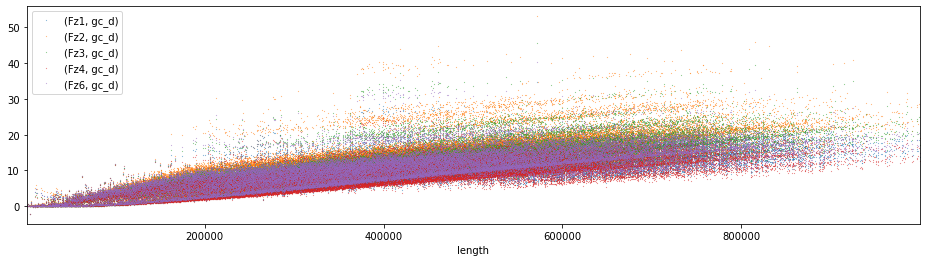

In [25]:
sm.los.set_index('length')[perf_attrs].sample(int(len(sm.los)/20)).plot(
    subplots=False, figsize=(16,4), linestyle=' ', marker='x', markersize=.6, alpha=.5)

## Mode Choice

In [26]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


In [27]:
# Run the logit model to calculate probabilities
sm.step_logit(workers=2, decimals=8, nchunks=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]


In [28]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(801985, 9)
(801985, 9)


In [29]:
sm.probabilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
1047,DE117,DE927,Fz3,1,0.0,0.869386,3.380082e-04,0.000000,0.130276
16807,DE149,DE711,Fz3,1,0.0,0.854830,4.189206e-07,0.026647,0.118522
9263,DE217,DEA1D,Fz4,1,0.0,0.721520,6.076250e-02,0.003359,0.214359
32216,DE731,DE149,Fz2,1,0.0,0.318308,3.572704e-07,0.143420,0.538271
75684,DEG05,DED2E,Fz6,1,0.0,0.835938,0.000000e+00,0.027026,0.137036


In [30]:
sm.utilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
35031,DE733,DE923,Fz2,-0.859109,-inf,-1.159633,-inf,-inf,-2.207839
60833,DEB12,DE715,Fz4,-0.387792,-inf,-0.536901,-inf,-inf,-2.364502
17684,DE22B,DED2C,Fz6,-2.337384,-inf,-2.377833,-10.870324,-7.852053,-5.677922
10627,DE142,DE271,Fz3,-1.031449,-inf,-1.088354,-inf,-4.352119,-4.984960
63158,DEB17,DE948,Fz4,-1.522956,-inf,-1.608575,-inf,-7.919522,-4.043845


In [31]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(Fz1, utility)","(Fz2, utility)","(Fz3, utility)","(Fz4, utility)","(Fz6, utility)","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
709147,1630.0,0.725763,DEA14,851,16470.0,380762,"[r_s_110039, r_s_110040, r_s_110041, r_s_11004...",-2.43723,6,DEG0C,...,-7.346963,-4.264624,-8.380915,-5.437591,-5.894372,0.014254,0.064225,0.005927,0.020783,0.018982


## Save model

In [32]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.39it/s]


In [33]:
# Save LoS table
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:20<00:00,  1.89it/s]


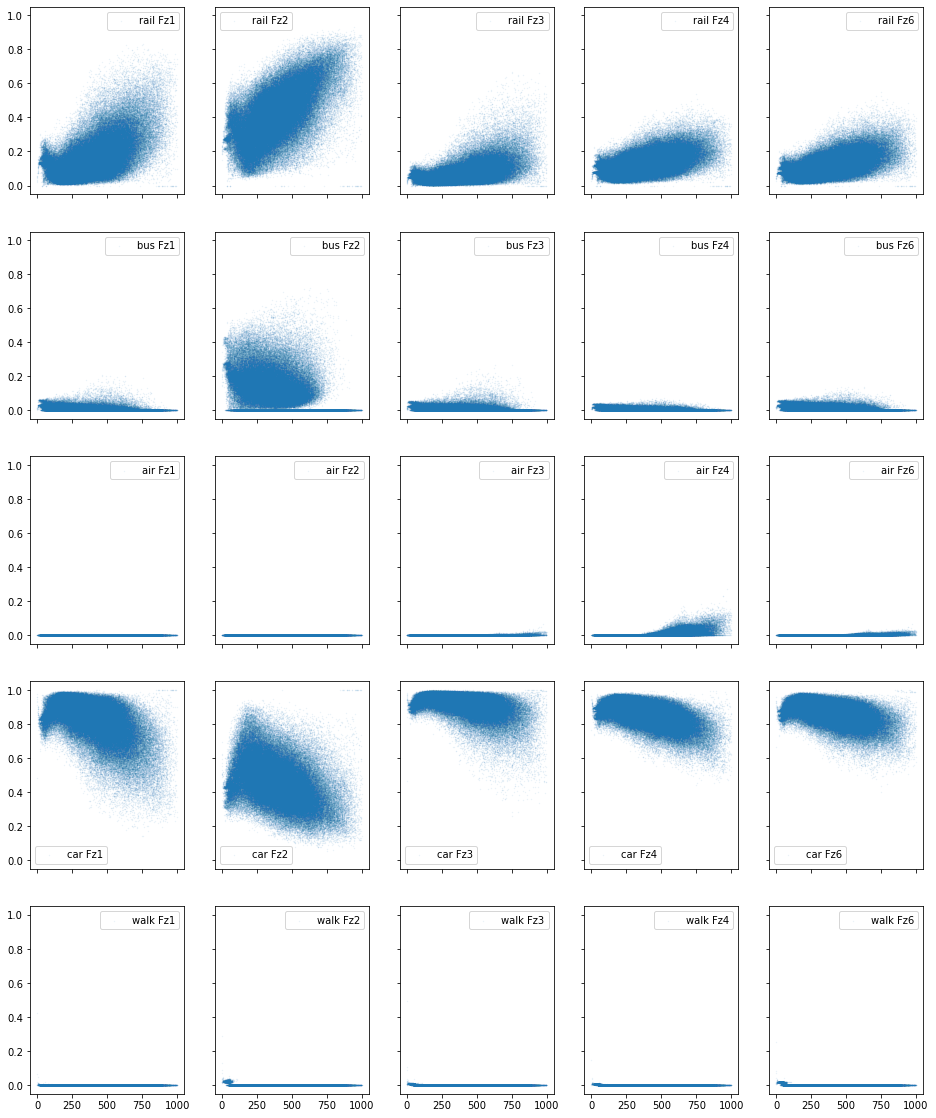

In [34]:
# Distance-distribution of probabilities
merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                on=['origin', 'destination'], how='inner')
fig, ax = plt.subplots(nrows=len(route_types), ncols=len(segments),
                       sharex='all', sharey='all', figsize=(16,20))
for i, mode in zip(range(len(route_types)), route_types):
    for j, seg in zip(range(len(segments)), segments):
        x = merged.loc[merged['segment']==seg, 'length'] / 1000
        y = merged.loc[merged['segment']==seg, mode]
        ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
        #p = np.poly1d(np.polyfit(x, y, deg=3))
        #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
        ax[i,j].legend()